# Lab 4 - Pageviews 

**Professor [Brian Keegan](https://www.brianckeegan.com)**  
**[Department of Information Science, CU Boulder](www.colorado.edu/cmci/academics/information-science)**  
This notebook is copyright and made available under the [Apache License v2.0](https://creativecommons.org/licenses/by-sa/4.0/) license.

This is the third of five lab notebooks that will explore how to analyze the structure of collaborations in Wikipedia data about users' revisions across multiple articles. This lab will extend the methods in the previous two labs about analyzing a single article's revision histories and analyzing the hyperlink networks around a single Wikipedia page. You do not need to be fluent in either to complete the lab, but there are many options for extending the analyses we do here by using more advanced queries and scripting methods.

**Acknowledgements**  
I'd like to thank the Wikimedia Foundation for the [PAWS system](https://wikitech.wikimedia.org/wiki/PAWS) and [related Wikitech infrastructure](https://wikitech.wikimedia.org/wiki/Main_Page) that this workbook runs within. Yuvi Panda, Aaron Halfaker, Jonathan Morgan, and Dario Taraborelli have all provided crucial support and feedback.

## Confirm that basic Python commands work

In [ ]:
a = 3
b = 4
c = 5
(c-a)**b

## Import modules and setup environment

Load up all the libraries we'll need to connect to the database, retreive information for analysis, and visualize results.

In [1]:
# Makes the plots appear within the notebook
%matplotlib inline

# Two fundamental packages for doing data manipulation
import numpy as np                   # http://www.numpy.org/
import pandas as pd                  # http://pandas.pydata.org/

# Two related packages for plotting data
import matplotlib.pyplot as plt      # http://matplotlib.org/
import seaborn as sb                 # https://stanford.edu/~mwaskom/software/seaborn/

# Package for requesting data via the web and parsing resulting JSON
import requests                      # http://docs.python-requests.org/en/master/
import json                          # https://docs.python.org/3/library/json.html
from bs4 import BeautifulSoup        # https://www.crummy.com/software/BeautifulSoup/bs4/doc/

# Two packages for accessing the MySQL server
import pymysql                       # http://pymysql.readthedocs.io/en/latest/
import os                            # https://docs.python.org/3.4/library/os.html

# Setup the code environment to use plots with a white background and DataFrames show more columns and rows
sb.set_style('whitegrid')
pd.options.display.max_columns = 100
pd.options.display.max_rows = 110

Define an article to examine pageview dynamics.

In [2]:
page_title = 'Nancy Reagan'

## Get pageview data for a single article

Details about the Wikimedia REST API for pageviews is available [here](https://wikimedia.org/api/rest_v1/). Unfortunately, this data end point only provides information going back to July 1, 2015.

This is what the API returns as an example.

In [3]:
# Get today's date and yesterday's date
today = pd.datetime.today()
yesterday = pd.datetime.today() - pd.to_timedelta('1 day')

# Convert to strings
today_s = pd.datetime.strftime(today,'%Y%m%d00')
yesterday_s = pd.datetime.strftime(yesterday,'%Y%m%d00')

# Get the pageviews for today and yesterday
url_string = 'http://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{0}/daily/{1}/{2}'
print(url_string.format(page_title.replace(' ','_'),yesterday_s,today_s))

http://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Nancy_Reagan/daily/2016102400/2016102500


Write a function to get the pageviews from January 1, 2015 (in practice, the start date will be as late as August or as early as May) until yesterday.

In [4]:
def get_daily_pageviews(page_title):
    url_string = 'http://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/{0}/daily/2015010100/{1}'
    today = pd.datetime.strftime(pd.datetime.today(),'%Y%m%d00')
    req = requests.get(url_string.format(page_title,today))

    json_s = json.loads(req.text)
    if 'items' in json_s.keys():
        _df = pd.DataFrame(json_s['items'])[['timestamp','views','article']]
        _df['timestamp'] = pd.to_datetime(_df['timestamp'],format='%Y%m%d00')
        _df['weekday'] = _df['timestamp'].apply(lambda x:x.weekday())
        return _df

Get the data for your page.

In [5]:
pageview_df = get_daily_pageviews(page_title)
pageview_df.head()

,timestamp,views,article,weekday
0,2015-07-01,2405,Nancy_Reagan,2
1,2015-07-02,2892,Nancy_Reagan,3
2,2015-07-03,3522,Nancy_Reagan,4
3,2015-07-04,6675,Nancy_Reagan,5
4,2015-07-05,4019,Nancy_Reagan,6


## Interpret page view results

What does the pageview activity look like? Are there any bursts of attention? What might these bursts be linked to?

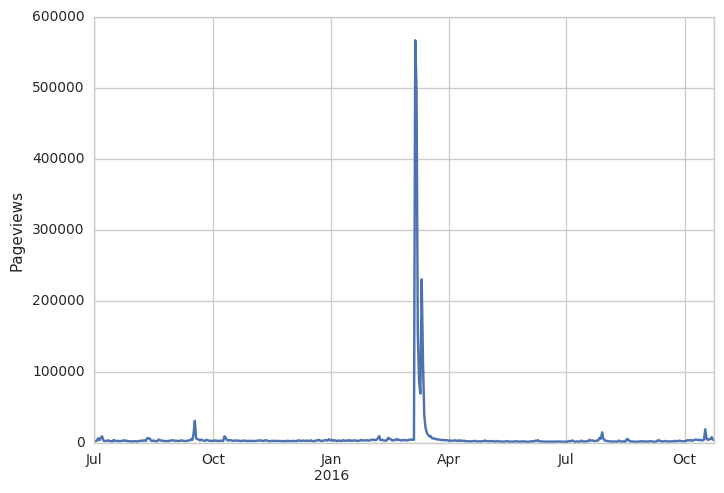

In [6]:
ax = pageview_df.plot.line(x='timestamp',y='views',logy=False,legend=False)
ax.set_xlabel('')
ax.set_ylabel('Pageviews')

Use a logarithmic scaling for the y-axis to see more of the detail in the lower-traffic days.

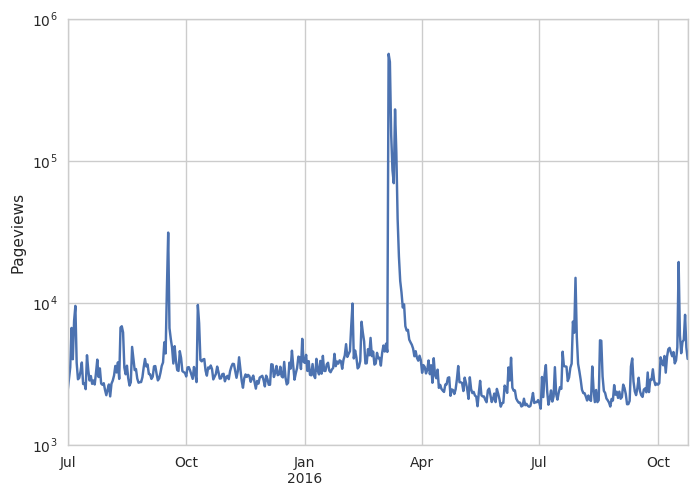

In [7]:
ax = pageview_df.plot.line(x='timestamp',y='views',logy=True,legend=False)
ax.set_xlabel('')
ax.set_ylabel('Pageviews')

What are the dates for the biggest pageview outliers? Here we define an "outlier" to be more than 3 standard deviations above the average number of pageviews over the time window.

In [8]:
std_threshold = 4
threshold_val = pageview_df['views'].mean() + pageview_df['views'].std() * std_threshold
peak_days = pageview_df[pageview_df['views'] > threshold_val]

peak_days.head(10)

,timestamp,views,article,weekday
249,2016-03-06,566963,Nancy_Reagan,6
250,2016-03-07,497348,Nancy_Reagan,0
251,2016-03-08,152656,Nancy_Reagan,1
254,2016-03-11,230407,Nancy_Reagan,4


How much of the total pageview activity occurred on these days compared to the rest of the pageviews?

In [9]:
peak_fraction = pageview_df.loc[peak_days.index,'views'].sum()/pageview_df['views'].sum()

print('{0:.1%} of all pageviews occurred on the {1} peak days.'.format(peak_fraction,len(peak_days)))

41.8% of all pageviews occurred on the 4 peak days.


How does pageview activity change over the course of a week?

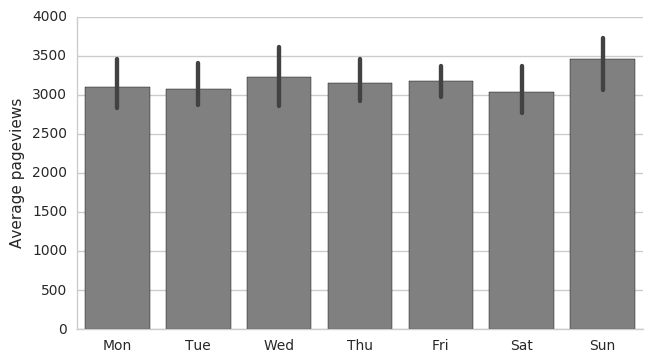

In [53]:
g = sb.factorplot(x='weekday',y='views',data=pageview_df,kind='bar',color='grey',
                  aspect=1.67,estimator=np.median)
ax = g.axes[0][0]
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Average pageviews')

## Compare pageviews to another page

Lets write a function that takes a list of article names and returns a DataFrame indexed by date, columned by articles, and values being the number of pageviews.

In [11]:
def get_multiple_pageviews(page_list):
    today = str(pd.datetime.today().date())
    multiple_pv_df = pd.DataFrame(index=pd.date_range('2015-05-01',today))
    for page in page_list:
        pv_df = get_daily_pageviews(page)
        try:
            multiple_pv_df[page] = pv_df.set_index('timestamp')['views'] 
        except:
            print("Error on: {0}".format(page))
            multiple_pv_df[page] = np.nan
    return multiple_pv_df.dropna(how='all')

Enter two related pages for which you want to compare their pageview behavior.

In [12]:
page_list = ['Nancy Reagan','Ronald Reagan']

Get both of their data.

In [13]:
# Get the data
multiple_pvs = get_multiple_pageviews(page_list)

# Show the top rows
multiple_pvs.head()

,Nancy Reagan,Ronald Reagan
2015-07-01,2405.0,11005.0
2015-07-02,2892.0,12482.0
2015-07-03,3522.0,12665.0
2015-07-04,6675.0,13881.0
2015-07-05,4019.0,13688.0


Plot the data.

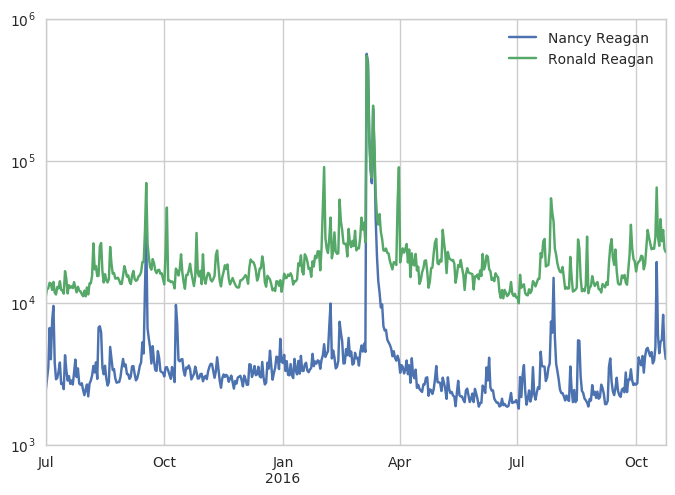

In [14]:
multiple_pvs.plot(logy=True)

What is the correlation coefficient between these two articles' behavior?

In [54]:
multiple_pvs.corr()

,Nancy Reagan,Ronald Reagan
Nancy Reagan,1.000000,0.976422
Ronald Reagan,0.976422,1.000000


How did the ratio between the two articles' pageviews change over time?

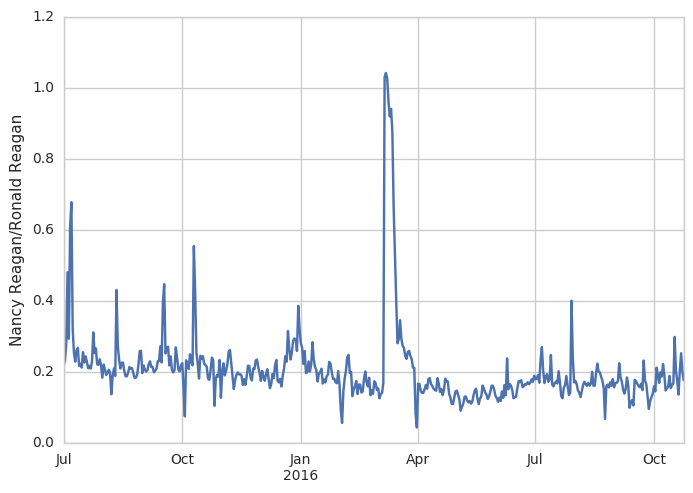

In [15]:
ratio_s = multiple_pvs[page_list[0]].div(multiple_pvs[page_list[1]])
ax = ratio_s.plot()
ax.set_ylabel('{0}/{1}'.format(page_list[0],page_list[1]))

## Get the pageviews for the hyperlink network

Use the functions for resolving redirects and getting page outlinks from prior labs.

In [16]:
# From http://stackoverflow.com/a/312464/1574687
def make_chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

def resolve_redirects(page_title_list):
    # Chunk the pages into a list of lists of size 50
    chunks = make_chunks(page_title_list,50)
    # Create an empty list to fill with the redirected titles
    redirected_page_titles = []
    # For each chunk try to get the redirects
    for chunk in chunks:
        # Create the query string that separates spaces within page titles by '+' 
        # and separates page titles by '|'
        page_titles_string = '|'.join([page.replace(' ','+') for page in chunk])
        # Put this large string into the URL
        url_string = 'https://en.wikipedia.org/w/api.php?action=query&format=json&prop=pageprops&titles={0}+&redirects=1'.format(page_titles_string)
        # Do the query and parse the JSON response into a dictionary
        req = json.loads(requests.get(url_string).text)
        # Convert the returned values containing redirects into a dictionary
        if 'redirects' in req['query'].keys():
            redirected_titles = {d['from']:d['to'] for d in req['query']['redirects']}
            # Add the redirected titles to the list
            for title in chunk:
                try:
                    #print(len(redirected_page_titles), title, redirected_titles[title])
                    redirected_page_titles.append(redirected_titles[title])
                # If they don't have a redirect just add the original title
                except KeyError:
                    #print(len(redirected_page_titles), '\nFrom: ', title, '\nTo: ', title)
                    redirected_page_titles.append(title)
        else:
            for title in chunk:
                redirected_page_titles.append(title)
    # Make sure the number of page titles remained the same, otherwise raise a warning
    if len(page_title_list) == len(redirected_page_titles):
        return redirected_page_titles
    else:
        print("WARNING! The number of page titles in the redirected list ({0}) is not equal to the input list ({1})".format(len(redirected_page_titles),len(page_title_list)))
        return redirected_page_titles

def get_page_outlinks(page_title,redirects=1):
    # Replace spaces with underscores
    #page_title = page_title.replace(' ','_')
    
    bad_titles = ['Special:','Wikipedia:','Help:','Template:','Category:','International Standard','Portal:','s:']
    
    # Get the response from the API for a query
    # After passing a page title, the API returns the HTML markup of the current article version within a JSON payload
    req = requests.get('https://en.wikipedia.org/w/api.php?action=parse&format=json&page={0}&redirects={1}&prop=text&disableeditsection=1&disabletoc=1'.format(page_title,redirects))
    
    # Read the response into JSON to parse and extract the HTML
    json_string = json.loads(req.text)
    
    # Initialize an empty list to store the links
    outlinks_list = [] 
    
    if 'parse' in json_string.keys():
        page_html = json_string['parse']['text']['*']

        # Parse the HTML into Beautiful Soup
        soup = BeautifulSoup(page_html,'lxml')

        # Delete tags associated with templates
        for tag in soup.find_all('tr'):
            tag.replace_with('')

        # For each paragraph tag, extract the titles within the links
        for para in soup.find_all('p'):
            for link in para.find_all('a'):
                if link.has_attr('title'):
                    title = link['title']
                    # Ignore links that aren't interesting
                    if all(bad not in title for bad in bad_titles):
                        outlinks_list.append(title)

        # For each unordered list, extract the titles within the child links
        for unordered_list in soup.find_all('ul'):
            for item in unordered_list.find_all('li'):
                for link in item.find_all('a'):
                    if link.has_attr('title'):
                        title = link['title']
                        # Ignore links that aren't interesting
                        if all(bad not in title for bad in bad_titles):
                            outlinks_list.append(title)

    return outlinks_list

Get the outlinks.

In [17]:
raw_outlinks = get_page_outlinks(page_title)
redirected_outlinks = resolve_redirects(raw_outlinks)

Get the data.

*This stage may take several minutes.*

In [18]:
# Get the data
hl_pvs_df = get_multiple_pageviews(redirected_outlinks + [page_title])

# Show the top rows
hl_pvs_df.head()

Error on: Anne Eisenhower Flottl (page does not exist)
Error on: Edit this at Wikidata


,President of the United States,Ronald Reagan,First Lady of the United States,Maryland,The Next Voice You Hear...,Night into Morning,Donovan's Brain (film),Screen Actors Guild,Governor of California,Senior Corps,"United States presidential election, 1980",White House china,Kennedy family,Recreational drug use,Just Say No,Astrology,Attempted assassination of Ronald Reagan,"Bel Air, Los Angeles",California,Alzheimer's disease,Death and state funeral of Ronald Reagan,Ronald Reagan Presidential Library,Embryonic stem cell,Sloane Hospital for Women,Midtown Manhattan,Edith Luckett Davis,Alla Nazimova,"Flushing, Queens",Roosevelt Avenue,"Bethesda, Maryland",Conservatism in the United States,Neurosurgery,Latin School of Chicago,Smith College,Massachusetts,March of Dimes,Poliomyelitis,Marshall Field's,ZaSu Pitts,Walter Huston,Spencer Tracy,Lady-in-waiting,Lute Song (musical),Mary Martin,Yul Brynner,Screen test,Metro-Goldwyn-Mayer,Typecasting (acting),Jane Powell,Debbie Reynolds,...,Death and funeral of Margaret Thatcher,Bess Truman,Heart failure,Presidential proclamation,Flag of the United States,Half-mast,Burial,"Simi Valley, California",Laura Bush,Steven Ford,Tricia Nixon Cox,Luci Baines Johnson,Caroline Kennedy,Anne Eisenhower Flottl (page does not exist),Arnold Schwarzenegger,Pete Wilson,Nancy Pelosi,Newt Gingrich,Edwin Meese,Mr. T,Maria Shriver,Wayne Newton,Johnny Mathis,Anjelica Huston,John Stamos,Tom Selleck,Bo Derek,Melissa Rivers,Prime Minister of Canada,James Baker,Diane Sawyer,Tom Brokaw,Ford Theatre,Schlitz Playhouse of Stars,General Electric Theater,Portrait of Jennie,It's a Big Country,Talk About a Stranger,Shadow in the Sky,The Dark Wave,Michael Beschloss,HarperCollins,Bobbs-Merrill Company,WhiteHouse.gov,C-SPAN,IMDb,Internet Broadway Database,Edit this at Wikidata,WorldCat,Nancy Reagan
2015-07-01,7656.0,11005.0,731.0,4018.0,37.0,NaN,31.0,580.0,1024.0,26.0,1265.0,86.0,2803.0,1632.0,203.0,3413.0,926.0,984.0,12467.0,7019.0,285.0,248.0,337.0,12.0,747.0,33.0,307.0,553.0,21.0,788.0,1227.0,803.0,44.0,670.0,4715.0,217.0,3488.0,315.0,179.0,375.0,1789.0,678.0,17.0,352.0,1673.0,99.0,1948.0,398.0,292.0,1581.0,...,155.0,257.0,2866.0,40.0,15928.0,409.0,613.0,511.0,1788.0,155.0,458.0,218.0,2801.0,NaN,45660.0,318.0,1216.0,1040.0,212.0,3905.0,5925.0,1146.0,837.0,2358.0,5143.0,4778.0,2472.0,1212.0,1380.0,432.0,1335.0,815.0,68.0,32.0,60.0,79.0,21.0,2.0,17.0,5.0,57.0,753.0,35.0,62.0,433.0,127.0,307.0,NaN,291.0,2405.0
2015-07-02,7884.0,12482.0,767.0,3914.0,23.0,1.0,36.0,576.0,1012.0,13.0,1399.0,74.0,2447.0,948.0,324.0,3270.0,1302.0,879.0,11068.0,5046.0,315.0,279.0,364.0,8.0,661.0,71.0,317.0,549.0,20.0,766.0,967.0,895.0,46.0,597.0,4371.0,233.0,3388.0,275.0,170.0,349.0,1633.0,640.0,12.0,315.0,2007.0,95.0,1654.0,379.0,301.0,1490.0,...,161.0,289.0,2785.0,65.0,17436.0,418.0,615.0,451.0,1717.0,318.0,462.0,391.0,2833.0,NaN,47047.0,299.0,1155.0,940.0,211.0,3400.0,6543.0,846.0,1053.0,2111.0,3990.0,5539.0,2143.0,1022.0,1060.0,421.0,1131.0,822.0,60.0,37.0,60.0,74.0,29.0,8.0,10.0,10.0,40.0,997.0,36.0,38.0,483.0,181.0,303.0,NaN,368.0,2892.0
2015-07-03,7702.0,12665.0,723.0,3509.0,20.0,4.0,49.0,600.0,926.0,12.0,1127.0,83.0,2413.0,782.0,219.0,2819.0,992.0,919.0,10135.0,4714.0,318.0,276.0,284.0,20.0,715.0,56.0,271.0,483.0,33.0,701.0,877.0,644.0,31.0,505.0,4113.0,230.0,2899.0,291.0,181.0,302.0,1527.0,675.0,13.0,343.0,2161.0,97.0,1813.0,371.0,332.0,1787.0,...,169.0,307.0,2306.0,40.0,17886.0,1058.0,532.0,441.0,1719.0,445.0,1347.0,451.0,2836.0,NaN,56594.0,264.0,996.0,858.0,155.0,2728.0,6644.0,899.0,1404.0,2103.0,3430.0,8163.0,2433.0,941.0,862.0,395.0,1005.0,1173.0,49.0,30.0,76.0,98.0,26.0,5.0,7.0,13.0,48.0,900.0,22.0,47.0,414.0,145.0,313.0,NaN,302.0,3522.0
2015-07-04,9850.0,13881.0,896.0,3582.0,30.0,2.0,74.0,569.0,899.0,18.0,1089.0,91.0,2787.0,763.0,215.0,2581.0,1074.0,927.0,10514.0,4620.0,344.0,292.0,190.0,15.0,644.0,111.0,351.0,439.0,15.0,657.0,1092.0,734.0,44.0,521.0,4437.0,180.0,2589.0,299.0,168.0,398.0,1682.0,641.0,20.0,411.0,2252.0,97.0,1685.0,424.0,2643.

What are the most-viewed articles in the hyperlink network?

In [19]:
most_viewed_articles = hl_pvs_df.cumsum().ix[str(yesterday.date())]
most_viewed_articles = most_viewed_articles.sort_values(ascending=False)
most_viewed_articles.head(10)

Barack Obama             17299567.0
Hillary Clinton          15980822.0
Ronald Reagan            10717782.0
Arnold Schwarzenegger     9488348.0
John F. Kennedy           8380108.0
Vietnam War               8027388.0
George W. Bush            7493812.0
Frank Sinatra             6924832.0
George H. W. Bush         6171021.0
Jimmy Carter              6163552.0
Name: 2016-10-24 00:00:00, dtype: float64

## Most and least correlated articles

Which articles are most correlated with each other?

In [58]:
# Log the pageview data to reduce skew from bursty outliers abd make the correlation table
hl_corr_df = hl_pvs_df.apply(np.log).corr()

# Correlation table is symmetric, drop one half of them
# From: http://stackoverflow.com/questions/34417685/melt-the-upper-triangular-matrix-of-a-pandas-dataframe
hl_corr_df = hl_corr_df.where(np.triu(np.ones(hl_corr_df.shape)).astype(np.bool))

# Unstack the DataFrame into a series and sort
hl_corr_s = hl_corr_df.unstack().sort_values(ascending=False)

# Drop NaNs
hl_corr_s = hl_corr_s.dropna()

# Drop values equal to 1
hl_corr_s = hl_corr_s[hl_corr_s < 1]

List out the 10 most correlated articles.

In [59]:
hl_corr_s.head(10)

United States presidential election, 1976  United States presidential election, 1980    0.982468
Maureen Reagan                             Patti Davis                                  0.941567
Michael Reagan                             Maureen Reagan                               0.936525
IMDb                                       Raisa Gorbacheva                             0.928562
Nancy Reagan                               Death and state funeral of Ronald Reagan     0.928399
                                           Edith Luckett Davis                          0.922449
New Hampshire primary                      Iowa caucuses                                0.920889
Maureen Reagan                             Jane Wyman                                   0.908607
Barbara Bush                               George H. W. Bush                            0.899796
Michael Reagan                             Ron Reagan                                   0.889573
dtype: float64

Inspect this correlation from the raw data.

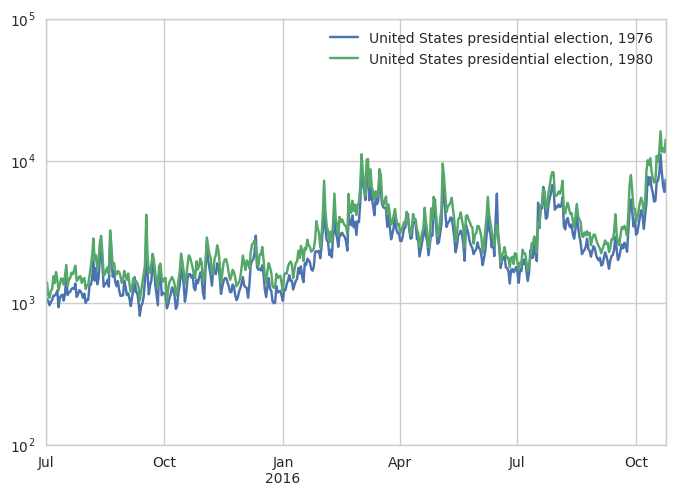

In [60]:
_df = hl_pvs_df[list(hl_corr_s.index[0])]

ax = _df.plot(logy=True)

Look at the 10 least-correlated articles.

In [61]:
hl_corr_s.tail(10)

United States presidential election, 1976  Garry Wills             -0.567288
Hillary Clinton                            Garry Wills             -0.583126
Wagon Train                                Garry Wills             -0.593748
IMDb                                       Dynasty (TV series)     -0.607038
Raisa Gorbacheva                           New Hampshire primary   -0.626839
IMDb                                       New Hampshire primary   -0.647504
Raisa Gorbacheva                           Iowa caucuses           -0.701979
IMDb                                       Iowa caucuses           -0.712014
Raisa Gorbacheva                           Garry Wills             -0.723211
IMDb                                       Garry Wills             -0.807172
dtype: float64

Plot the correlation between the two most anti-correlated articles. These show some kinda wacky properties that are interesting to explore or think more about.

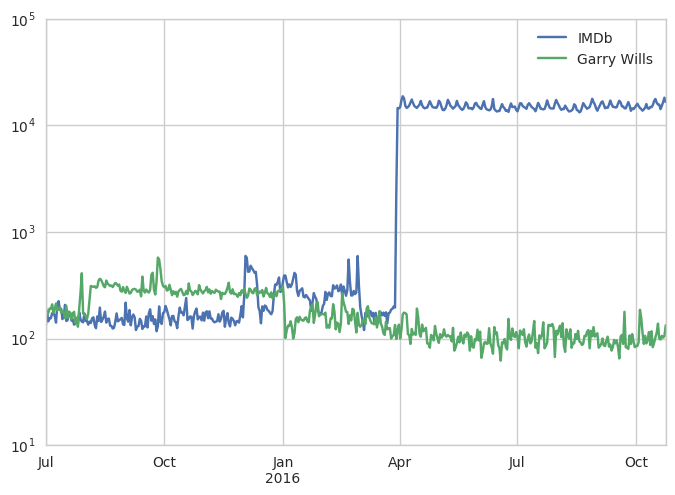

In [62]:
_df = hl_pvs_df[list(hl_corr_s.index[-1])]

ax = _df.plot(logy=True)

## Pageview correlation and link location

Is there a relationship between the position of the link on the page and the correlation between the linked article's pageviews and the seed article's pageviews? For instance, links closer to the top of the page might reflect more important topics while links towards the end of the page might be less relevant.

In [25]:
link_corrs = []

for num,link in enumerate(redirected_outlinks):
    try:
        link_corrs.append({'position':num,'title':link,'corr':hl_corr_s.ix[(page_title,link)]})
    except KeyError:
        print("Error on: {0}".format(link))

Error on: Anne Eisenhower Flottl (page does not exist)
Error on: Edit this at Wikidata


Plot the results.

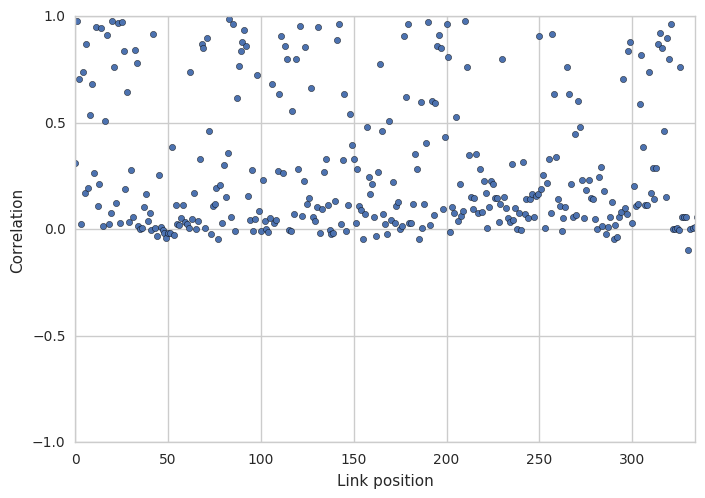

In [26]:
ax = pd.DataFrame(link_corrs).plot.scatter(x='position',y='corr')
ax.set_xlim((0,len(link_corrs)))
ax.set_ylim((-1,1))
ax.set_xlabel('Link position')
ax.set_ylabel('Correlation')

## Get page revisions

In this section, we'll repurpose and adapt code from the last lab to get data about page revisions. Rather than looking at the number of times a user contributed to a given article, we'll simply count the number of times the article was edited on a given date.

In [27]:
def get_page_edits_by_date(page_title,conn,date_string='2014-12-31'):
    """ Takes a page title and returns the number of revisions made on each date.
      page_title = a string for the page title to get its revisions
      date_string = a string for the date in YYYY-MM-DD format
      conn = a database connection
      
    Returns:
      A DataFrame with username, page title, edit count, and min/max timestamps
    """
    # In case you pass a page title with spaces in it, replace the spaces with underscores
    page_title = page_title.replace(' ','_').encode('utf8').decode('latin1')
    
    # The MySQL query string used to retrieve the data. By line, it is
    ## converting the timestamp to a date and 
    ## counting the number of elements
    ## from the "revisions" table
    ## joining the "page" table on it
    ## using the page_id and rev_page columns as keys
    ## limiting the results to entries that have the pagetitle, 
    ## occur in the namespace, and happen after Dec 31, 2014
    ## grouping the results by date
    s = """
            SELECT
                DATE(rev_timestamp) as date,
                page_title,
                COUNT(*) as edits
            FROM 
                revision 
            JOIN 
                page ON page.page_id = revision.rev_page
            WHERE 
                page.page_title = "{0}" 
                AND page_namespace = 0
                AND DATE(rev_timestamp) > '{1}'
            GROUP BY
                date
        """.format(page_title,date_string)

    # Use the connection to run the query and return the results as a DataFrame
    _df = pd.read_sql_query(s,conn)
    
    _df['page_title'] = _df['page_title'].str.decode('utf8')
    _df['page_title'] = _df['page_title'].str.replace('_',' ')
    
    # Return the data, with a clean index
    return _df

def get_neighbors_revisions(page_title,conn):
    """ Takes a page title and returns revisions for the page and its neighbors.
      page_title = a string for the page title to get its revisions
      
    Returns:
      A pandas DataFrame containing all the page revisions.
    """
    # Get the outlinks from the page and include the page itself in the list
    alters = get_page_outlinks(page_title) + [page_title]
    # Resolve the redirects in the list of alters
    alters = list(set(resolve_redirects(alters)))
    # Create an empty container to hold the DataFrames
    df_list = []
    # For each page, get the revision counts and append to the df_list
    for alter in alters:
        _df = get_page_edits_by_date(alter,conn)
        df_list.append(_df)
    # Concatenate the list of revision count DataFrames into a giant DataFrame
    df = pd.concat(df_list)
    # Return the data
    return df.reset_index(drop=True)

Get the authentication information and connect to the database.

In [28]:
host, user, password = os.environ['MYSQL_HOST'], os.environ['MYSQL_USERNAME'], os.environ['MYSQL_PASSWORD']
conn = pymysql.connect(host=host,user=user,password=password,database='enwiki_p',connect_timeout=3600)
conn.cursor().execute('use enwiki_p');

Get the number of revisions per day for all the articles.

In [29]:
hl_daily_rev_df = get_neighbors_revisions(page_title,conn)
hl_daily_rev_df.head()

,date,page_title,edits
0,2015-01-02,"Santa Monica, California",1.0
1,2015-01-06,"Santa Monica, California",1.0
2,2015-01-23,"Santa Monica, California",1.0
3,2015-01-27,"Santa Monica, California",1.0
4,2015-02-08,"Santa Monica, California",1.0


Reindex the edit data so it's starting and ending on the same dates as the pageviews data.

In [33]:
# Convert into a format like the hl_pageviews DataFrame
# Index are dates between Jan 1, 2015 and today; columns are article titles; values are number of edits
hl_edits_df = hl_daily_rev_df.set_index(['date','page_title'])['edits'].unstack(1)

# Reindex so dates are continuous
pv_start_ix = str(hl_pvs_df.index.min().date())
pv_end_ix = str((pd.Timestamp.today() - pd.Timedelta('1 d')).date())
_date_range = pd.date_range(pv_start_ix,pv_end_ix)
hl_edits_df = hl_edits_df.reindex(index=_date_range)

# Fill in empty observations with 0s
hl_edits_df = hl_edits_df.fillna(0)

hl_edits_df.head()

page_title,1996 Republican National Convention,ABC News,Adolfo (designer),Albert Brooks,Alla Nazimova,Alzheimer's disease,Anjelica Huston,Ann Sothern,Arnold Schwarzenegger,Astrology,Attempted assassination of Ronald Reagan,"Austin, Texas",Barack Obama,Barbara Bush,Barbara Stanwyck,Barbara Walters,Bel Air Church,"Bel Air, Los Angeles",Bess Truman,"Bethesda, Maryland",Betsy Bloomingdale,Betty Ford,"Beverly Hills, California",Bill Blass,Bo Derek,Bobbs-Merrill Company,Bosley Crowther,Brenda Marshall,Brian Mulroney,Brian Williams,Burial,C-SPAN,CNN,California,California Arts Council,"Carmichael, California",Caroline Kennedy,"Charles, Prince of Wales",Charlton Heston,Chasen's,Child and adolescent psychiatry,Clark Gable,Cold War,Condoleezza Rice,Congressional Gold Medal,Conservatism in the United States,Council of Fashion Designers of America,Crash Landing (1958 film),Daytop,Death and funeral of Margaret Thatcher,...,Senior Corps,Shadow in the Sky,Shadow on the Wall (film),"Simi Valley, California",Sloane Hospital for Women,Smith College,Spencer Tracy,State dinner,Stem cell,Steven Ford,Stop the Madness,Strom Thurmond,Talk About a Stranger,Ted Kennedy,The Dark Wave,The Doctor and the Girl,The New York Times,The Next Voice You Hear...,The Tall Man (TV series),The Victors,The Washington Post,Tom Brokaw,Tom Selleck,Tricia Nixon Cox,Typecasting (acting),U.S. News & World Report,United Nations General Assembly,United States Capitol,United States Capitol rotunda,United States Secret Service,"United States presidential election, 1976","United States presidential election, 1980",Van Cliburn,Vanity Fair (magazine),Vietnam War,Wagon Train,Walter Huston,Washington Hilton,Washington National Cathedral,Wayne Newton,White House,White House Chief of Staff,White House china,WhiteHouse.gov,William Holden,Wolf Blitzer,WorldCat,Yul Brynner,ZaSu Pitts,Zachary Scott
2015-07-01,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2015-07-02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2015-07-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,14.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-07-05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Are pageviews and edits correlated with each other?

In [64]:
_s1 = hl_pvs_df[page_title]
_s2 = hl_edits_df[page_title]

np.corrcoef(_s1.apply(np.log),_s2)[0][1]

0.55355405969832583

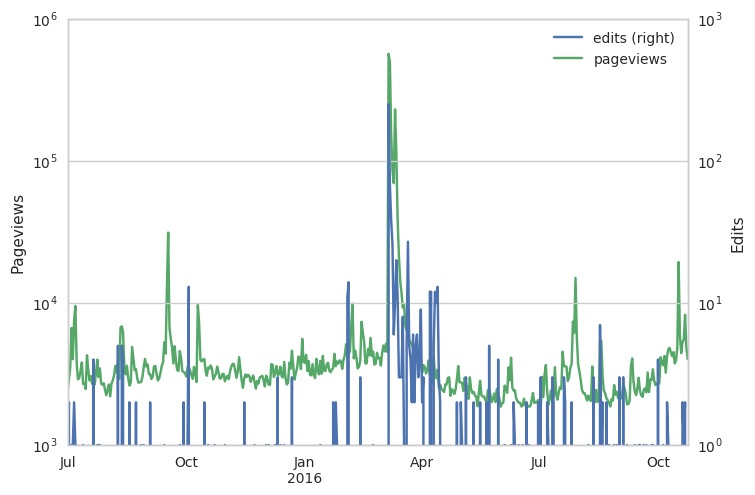

In [35]:
single_pv_edits_df = pd.DataFrame({'pageviews':_s1,'edits':_s2})
ax = single_pv_edits_df.plot(secondary_y='edits',logy=True)
ax.right_ax.set_yscale('log')
ax.set_ylabel('Pageviews')
ax.right_ax.set_ylabel('Edits')

## Can Wikipedia supply information to keep up with demand?

The ratio between the cumulative pageviews and cumulative edits.

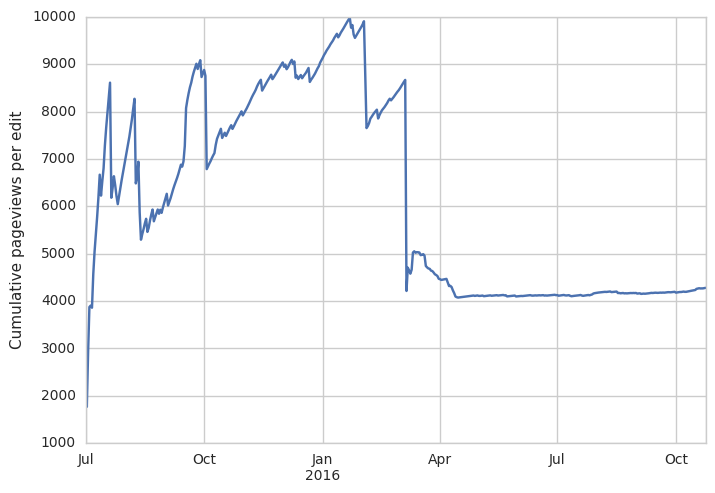

In [36]:
ax = (_s1.cumsum()/_s2.cumsum()).plot()

ax.set_ylabel('Cumulative pageviews per edit')

In [37]:
def zscore(series):
    return np.abs((series - series.mean())/series.std())

Look at the normalized ([z-score](https://en.wikipedia.org/wiki/Standard_score])) excitation and relaxation in edits and pageviews by day. Each point is a single day in the article's history and they're connected if they come one day after each other. Values along the diagonal in red suggest that increases in attention to the article are matched by similar increases in editing activity on the article. Alternatively, data points in the upper-left triangle suggest increases in pageviews are not matched by increases in edits while data points in the lower-right triangle suggest increases in edits are not matched by increases in pageviews.

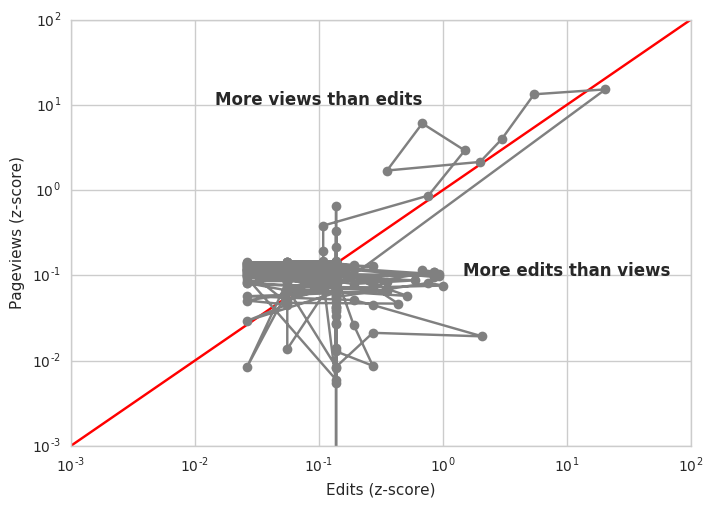

In [38]:
f,ax = plt.subplots(1,1)

ax.set_xlabel('Edits (z-score)')
ax.set_ylabel('Pageviews (z-score)')
ax.set_xlim((1e-3,1e2))
ax.set_ylim((1e-3,1e2))
ax.set_xscale('log')
ax.set_yscale('log')

plt.text(1e-1,1e1,'More views than edits',ha='center',weight='bold')
plt.text(1e1,1e-1,'More edits than views',ha='center',weight='bold')

plt.plot([1e-3,1e2],[1e-3,1e2],axes=ax,c='r')

_s1 = zscore(hl_edits_df[page_title])
_s2 = zscore(hl_pvs_df[page_title])
plt.plot(_s1,_s2,'o-',axes=ax,c='grey');

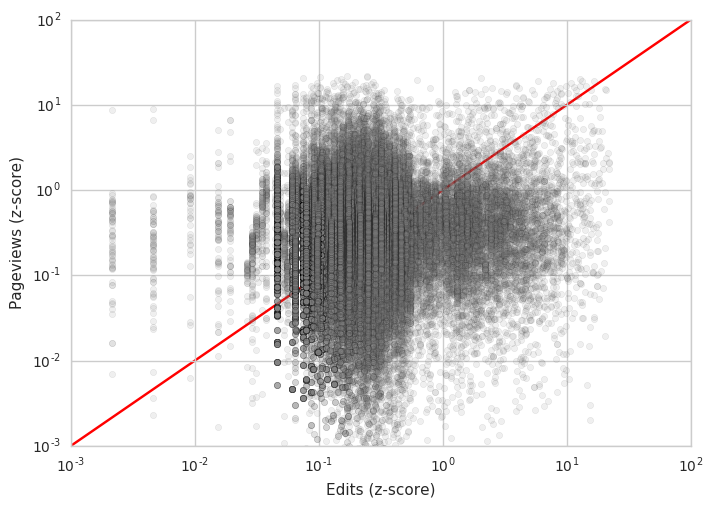

In [43]:
f,ax = plt.subplots(1,1)

ax.set_xlabel('Edits (z-score)')
ax.set_ylabel('Pageviews (z-score)')
ax.set_xlim((1e-3,1e2))
ax.set_ylim((1e-3,1e2))
ax.set_xscale('log')
ax.set_yscale('log')

for page in hl_edits_df.columns:
    _s1 = zscore(hl_edits_df[page])
    _s2 = zscore(hl_pvs_df[page])
    #plt.plot(_s1.ix[_s2.index],_s2,'.-',axes=ax,alpha=.125,c='grey')
    plt.scatter(_s1,_s2,axes=ax,alpha=.125,c='grey')
    
# Diagonal red line showing perfect matching
plt.plot([1e-3,1e2],[1e-3,1e2],axes=ax,c='r',zorder=-1);

## Did a burst of pageviews diffuse to adjacent pages?

On what day did the maximum number of pageviews occur?

In [40]:
page_max_pv_date = hl_pvs_df[page_title].idxmax()
print(page_max_pv_date.date())

2016-03-06


In [41]:
# For each article, what was the date when the maximum number of 
max_pv_dates_df = hl_pvs_df.idxmax()

# Check whether these dates were also the page_max_pv_date
_fraction = max_pv_dates_df.isin([page_max_pv_date,page_max_pv_date+1]).sum()/len(max_pv_dates_df)

print("{0:.1%} of articles in the hyperlink network also had the max pageview on the same date as the article.".format(_fraction))

19.1% of articles in the hyperlink network also had the max pageview on the same date as the article.


What are these "co-bursting" pages?

In [68]:
cobursting_pv_articles = max_pv_dates_df[max_pv_dates_df.isin([page_max_pv_date,page_max_pv_date+1])].sort_index()
cobursting_pv_articles

Adolfo (designer)                          2016-03-07
Alla Nazimova                              2016-03-06
Barbara Bush                               2016-03-06
Bel Air, Los Angeles                       2016-03-06
Bess Truman                                2016-03-06
Betty Ford                                 2016-03-06
Brenda Marshall                            2016-03-06
Chasen's                                   2016-03-07
Death and state funeral of Gerald Ford     2016-03-07
Death and state funeral of Ronald Reagan   2016-03-06
Donald Regan                               2016-03-06
Donovan's Brain (film)                     2016-03-07
East Gate Bel Air, Los Angeles             2016-03-07
Edith Luckett Davis                        2016-03-07
First Lady of the United States            2016-03-06
General Electric Theater                   2016-03-07
Gerald Ford                                2016-03-07
Governor of California                     2016-03-06
Governor's Mansion State His

## Did this burst of pageviews translate into edits on these pages as well?

Get the articles with the peak amount of activity by date and then subset to only include those articles whose peak dates are the same as the peak pageview dates.

In [67]:
max_edits_dates_df = hl_edits_df.idxmax()
cobursting_edit_articles = max_edits_dates_df[max_edits_dates_df.isin([page_max_pv_date,page_max_pv_date+1])].sort_index()
cobursting_edit_articles

page_title
Alla Nazimova                             2016-03-07
Council of Fashion Designers of America   2016-03-07
Edith Luckett Davis                       2016-03-07
Framing (social sciences)                 2016-03-07
Hellcats of the Navy                      2016-03-07
Just Say No                               2016-03-07
Maria Shriver                             2016-03-06
Maureen Reagan                            2016-03-07
Michael Reagan                            2016-03-06
Mr. T                                     2016-03-07
Nancy Reagan                              2016-03-06
Patti Davis                               2016-03-07
Rancho Mirage, California                 2016-03-06
Ronald Reagan Presidential Library        2016-03-07
The Next Voice You Hear...                2016-03-06
WorldCat                                  2016-03-07
dtype: datetime64[ns]

How many edits beyond the target article did this translate into? Subset the dataframe to the relevant dates and articles and inspect.

In [78]:
dates = [page_max_pv_date,page_max_pv_date+1]
cobursting_edit_articles_list = list(set(cobursting_edit_articles.index) - set(page_title))
cobursting_hl_edits_df = hl_edits_df.loc[dates,cobursting_edit_articles.index]
cobursting_hl_edits_df

page_title,Alla Nazimova,Council of Fashion Designers of America,Edith Luckett Davis,Framing (social sciences),Hellcats of the Navy,Just Say No,Maria Shriver,Maureen Reagan,Michael Reagan,Mr. T,Nancy Reagan,Patti Davis,"Rancho Mirage, California",Ronald Reagan Presidential Library,The Next Voice You Hear...,WorldCat
2016-03-06,0.0,0.0,5.0,0.0,1.0,2.0,9.0,3.0,15.0,0.0,251.0,1.0,10.0,0.0,2.0,0.0
2016-03-07,3.0,6.0,6.0,8.0,11.0,4.0,1.0,10.0,7.0,10.0,68.0,5.0,0.0,6.0,0.0,4.0


Now sum up all these edits.

In [79]:
cobursting_hl_edits_df.sum().sum()

448.0